In [24]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt

In [14]:
def plot2d(data):
	data.plot(kind='scatter', x='Easting', y='Northing')

def plot3d(data, title):
	fig = plt.figure()
	ax = fig.add_subplot(projection='3d')
	ax.scatter(data['Easting'], data['Northing'], data['WaterDepth'])
	ax.set_xlabel('Easting')
	ax.set_ylabel('Northing')
	ax.set_label
	ax.set_zlabel('WaterDepth')
	ax.set_title(title)
	plt.show()

In [7]:
telemetry = pd.read_csv('./telemetry_cleaned.csv')

In [9]:
X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10619)

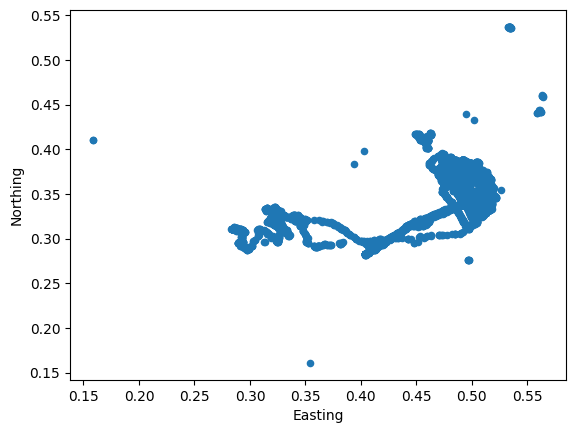

In [13]:
plot2d(X)

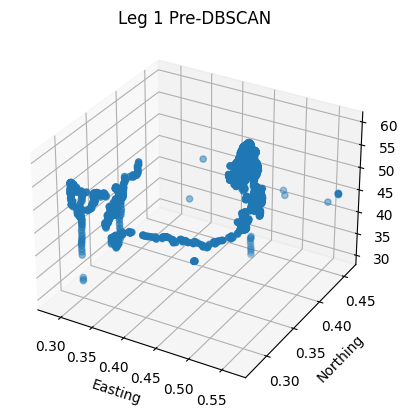

In [19]:
plot3d(X, 'Leg 1 Pre-DBSCAN')

## DBSCAN

### Grid Search function

This function accepts an input dataset and a list of options. The function will iterate through each combination of these options in order to find the best results.

In [76]:
import itertools

def grid_search_dbscan(data: pd.DataFrame, options: dict[str, tuple], verbose=False) -> list[dict[str, int]]:
	results = []

	# Iterate through each combination of options
	# And perform a DBSCAN evaluation
	option_combs = itertools.product(*options.values())

	for eps, min_samples in list(option_combs):
		if verbose: print(f'Running eps={eps}, min_samples={min_samples}')

		db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
		labels = db.labels_

		# Get estimated number of clusters and noise points
		clusters = len(set(labels)) - (1 if -1 in labels else 0)
		noise = list(labels).count(-1)

		# Evaluate result
		silhouette = metrics.silhouette_score(X, labels)

		if verbose: print(f'Finished with silhouette={silhouette}')

		results.append({
			"params": { "eps": eps, "min_samples": min_samples },
			"eval": {
				"clusters": clusters,
				"noise": noise,
				"silhouette": silhouette
			}
		})

	return results

### Evaluation

In [80]:
# Run grid search with the following options
options = {
	"eps": [0.1, 0.15, 0.2, 0.3],
	"min_samples": [2, 5, 10]
}

results = grid_search_dbscan(X, options)

# Find best result
highest = 0
best = None

for res in results:
	sil = res['eval']['silhouette']

	if sil > highest:
		highest = sil
		best = res

print(f'Best result was:\n\t{best["eval"]}\nusing params:\n\t{best["params"]}')

Best result was:
	{'clusters': 10, 'noise': 134, 'silhouette': 0.718844580025408}
using params:
	{'eps': 0.15, 'min_samples': 10}


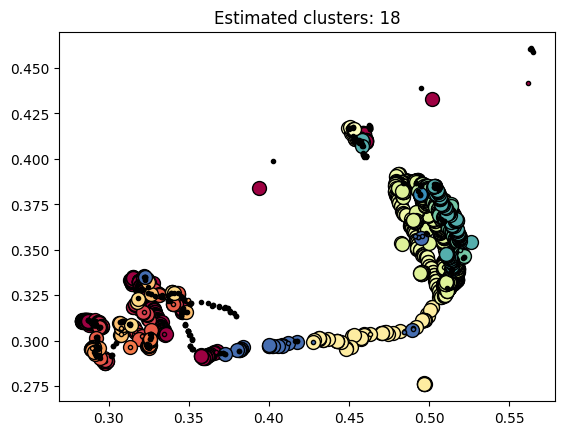

In [31]:
def plot_clusters(db, labels, clusters):
	unique_labels = set(labels)
	core_samples_mask = np.zeros_like(labels, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True

	colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

	for k, color in zip(unique_labels, colors):
		if k == -1:
			# Black used for noise
			color = [0, 0, 0, 1]

		class_member_mask = labels == k

		core_samples = X[class_member_mask & core_samples_mask]

		plt.plot(
			core_samples['Easting'],
			core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=10,
		)

		non_core_samples = X[class_member_mask & ~core_samples_mask]
		plt.plot(
			non_core_samples['Easting'],
			non_core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=3,
		)

	plt.title(f'Estimated clusters: {clusters}')
	plt.show()